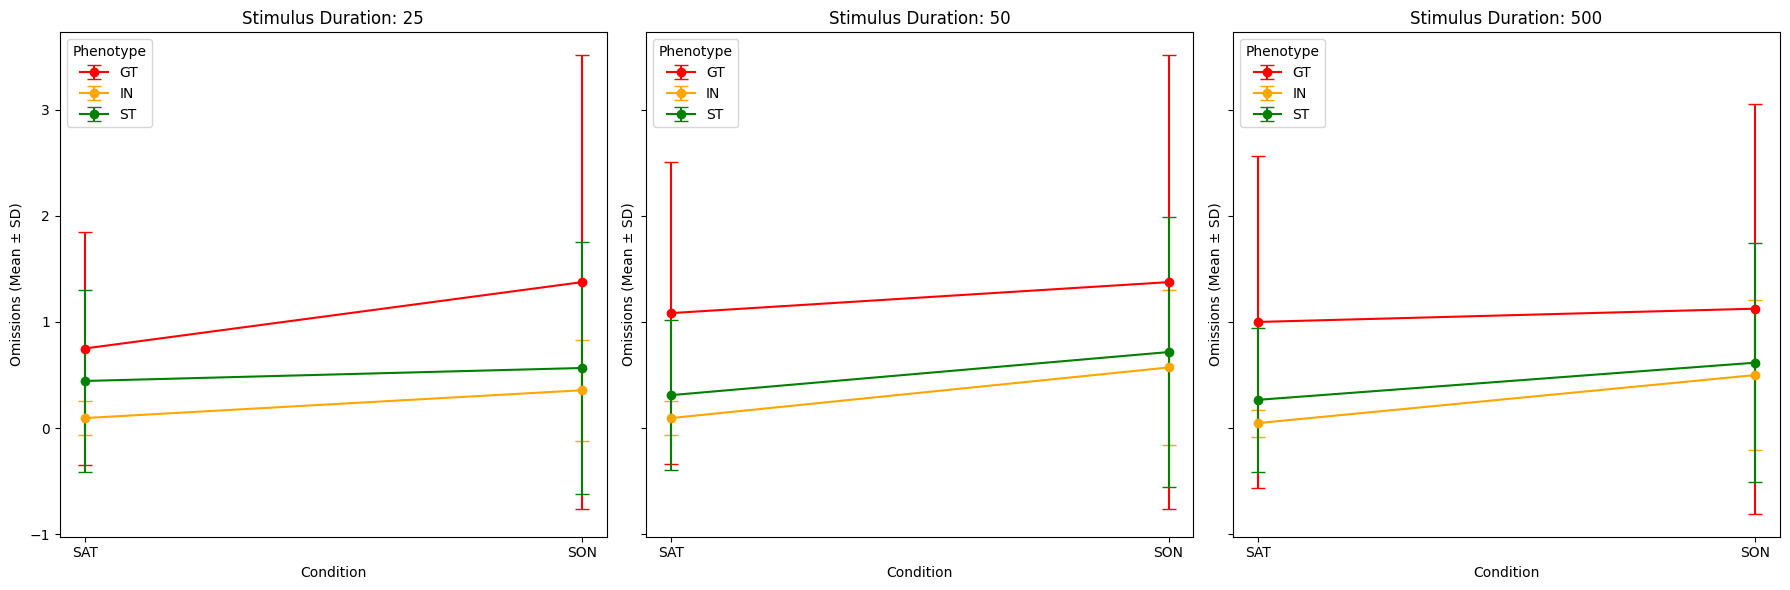

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load the Excel file and list the sheet names to locate the 'tidy' sheet
file_path = 'SATson1.xlsx'
excel_data = pd.ExcelFile(file_path)

# Check sheet names
excel_data.sheet_names
# Load the 'tidy' sheet into a DataFrame
tidy_df = pd.read_excel(file_path, sheet_name='tidy')

# Display the first few rows of the data to understand its structure
tidy_df.head()

colors = {'ST': 'green', 'IN': 'orange', 'GT': 'red'}

# Now we will perform the same steps but focusing on the 'om' (omissions) metric

# Grouping the data to calculate mean and standard deviation for 'om'
om_summary_df = tidy_df.groupby(['phenotype', 'stimulus_duration', 'condition']).agg(
    om_mean=('om', 'mean'),
    om_sd=('om', 'std')
).reset_index()

# Function to plot the graphs for 'om' for each stimulus duration
def plot_om_graphs_for_stimulus(stimulus_duration, ax):
    # Filter the data for the current stimulus duration
    data = om_summary_df[om_summary_df['stimulus_duration'] == stimulus_duration]
    
    for phenotype in data['phenotype'].unique():
        phenotype_data = data[data['phenotype'] == phenotype]
        
        # Plotting the mean line with error bars for SD
        ax.errorbar(phenotype_data['condition'], 
                    phenotype_data['om_mean'], 
                    yerr=phenotype_data['om_sd'], 
                    label=phenotype, 
                    color=colors[phenotype], 
                    capsize=5, 
                    marker='o')
        
    ax.set_title(f'Stimulus Duration: {stimulus_duration}')
    ax.set_xlabel('Condition')
    ax.set_ylabel('Omissions (Mean ± SD)')
    ax.legend(title="Phenotype")

# Creating side-by-side plots for each stimulus duration
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for stimulus durations 25, 50, and 500
for i, duration in enumerate([25, 50, 500]):
    plot_om_graphs_for_stimulus(duration, axs[i])

plt.tight_layout()
plt.show()



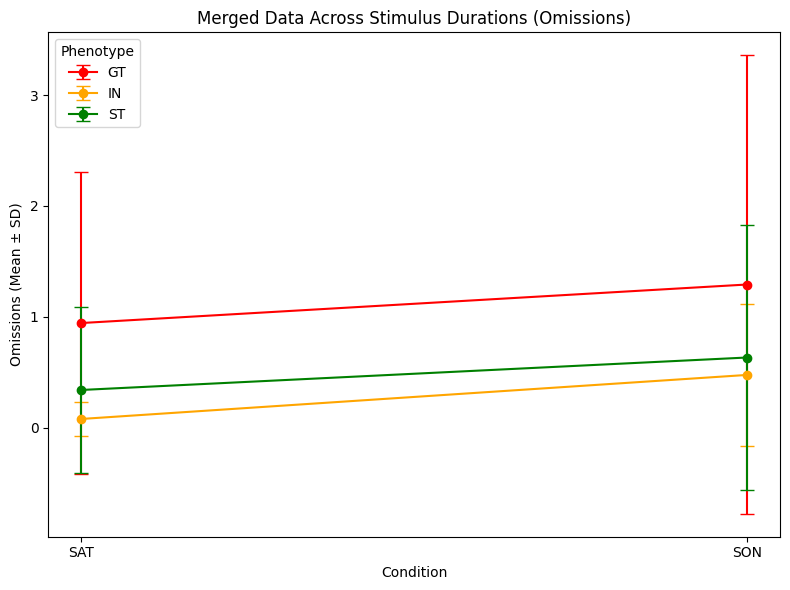

In [2]:
# Now, let's compute the mean across stimulus durations for 'om' for each phenotype and condition
merged_om_summary_df = om_summary_df.groupby(['phenotype', 'condition']).agg(
    om_mean=('om_mean', 'mean'),
    om_sd=('om_sd', 'mean')  # Merging SD by averaging as well
).reset_index()

# Creating a new plot for the merged stimulus durations for 'om'
fig, ax = plt.subplots(figsize=(8, 6))

for phenotype in merged_om_summary_df['phenotype'].unique():
    # Filter data by phenotype
    phenotype_data = merged_om_summary_df[merged_om_summary_df['phenotype'] == phenotype]
    
    # Plot the mean line with error bars for SD
    ax.errorbar(phenotype_data['condition'], 
                phenotype_data['om_mean'], 
                yerr=phenotype_data['om_sd'], 
                label=phenotype, 
                color=colors[phenotype], 
                capsize=5, 
                marker='o')

ax.set_title('Merged Data Across Stimulus Durations (Omissions)')
ax.set_xlabel('Condition')
ax.set_ylabel('Omissions (Mean ± SD)')
ax.legend(title="Phenotype")

plt.tight_layout()
plt.show()


In [4]:
import pandas as pd
import pingouin as pg

# Load your dataset
file_path = 'SATson1.xlsx'  # Replace with your actual file path
tidy_df = pd.read_excel(file_path, sheet_name='tidy')

# Print column names to verify
print("Columns in the dataset:\n", tidy_df.columns)

# Ensure we are filtering the right columns for 'om' (Omissions)
if 'om' in tidy_df.columns:
    # Filtering necessary columns for analysis (focus on phenotype, condition, and om)
    om_df = tidy_df[['phenotype', 'animal_id', 'condition', 'om']]

    # Running the mixed-design ANOVA
    anova_results = pg.mixed_anova(
        dv='om', 
        within='condition', 
        between='phenotype', 
        subject='animal_id', 
        data=om_df
    )

    # Print ANOVA results
    print("ANOVA Results:\n", anova_results)

    # Check for significant factors and run Bonferroni post-hoc tests if needed
    significant_factors = anova_results[anova_results['p-unc'] < 0.05]['Source'].tolist()

    if significant_factors:
        post_hocs = pg.pairwise_ttests(
            dv='om', 
            within='condition', 
            between='phenotype', 
            subject='animal_id', 
            data=om_df, 
            padjust='bonferroni'
        )
        print("\nPost-hoc Results (Bonferroni corrected):\n", post_hocs)
    else:
        print("\nNo significant factors found.")
else:
    print("'om' column not found in the dataset.")


Columns in the dataset:
 Index(['phenotype', 'animal_id', 'stimulus_duration', 'condition', 'hits',
       'misses', 'fa', 'cr', 'om'],
      dtype='object')
ANOVA Results:
         Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0    phenotype  4.876334    2   19  2.438167  1.805496  0.191480  0.159701   
1    condition  0.846195    1   19  0.846195  6.881001  0.016736  0.265871   
2  Interaction  0.079399    2   19  0.039700  0.322824  0.727995  0.032865   

   eps  
0  NaN  
1  1.0  
2  NaN  

Post-hoc Results (Bonferroni corrected):
                 Contrast condition    A    B Paired Parametric         T  \
0              condition         -  SAT  SON   True       True -2.712079   
1              phenotype         -   GT   IN  False       True  0.950747   
2              phenotype         -   GT   ST  False       True  0.794442   
3              phenotype         -   IN   ST  False       True -0.873990   
4  condition * phenotype       SAT   GT   IN  False   

C:\Users\pfh3221\AppData\Roaming\Python\Python38\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
